In [1]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import StringType, IntegerType, BooleanType
from pyspark.ml.feature import StopWordsRemover, RegexTokenizer
from pyspark.ml.stat import Correlation

In [3]:
#start the spark session
spark = SparkSession.builder.appName("ETL Pipeline").getOrCreate()

In [4]:
#upload your dataset
from google.colab import files
uploaded = files.upload()

Saving chatgpt1.csv to chatgpt1 (2).csv


In [5]:
import pandas as pd
df = pd.read_csv("chatgpt1.csv")

In [6]:
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, TimestampType

# define the schema for the dataframe
schema = StructType([
    StructField("Datetime", TimestampType(), True),
    StructField("Tweet Id", StringType(), True),
    StructField("Text", StringType(), True),
    StructField("Username", StringType(), True),
    StructField("Permalink", StringType(), True),
    StructField("User", StringType(), True),
    StructField("Outlinks", StringType(), True),
    StructField("CountLinks", IntegerType(), True),
    StructField("ReplyCount", IntegerType(), True),
    StructField("RetweetCount", IntegerType(), True),
    StructField("LikeCount", IntegerType(), True),
    StructField("QuoteCount", IntegerType(), True),
    StructField("ConversationId", StringType(), True),
    StructField("Language", StringType(), True),
    StructField("Source", StringType(), True),
    StructField("Media", StringType(), True),
    StructField("QuotedTweet", StringType(), True),
    StructField("MentionedUsers", StringType(), True),
    StructField("hashtag", StringType(), True),
    StructField("hastag_counts", IntegerType(), True)
])

In [7]:
# create the dataframe with the specified schema
df = spark.read.csv("chatgpt1.csv", header=True, schema=schema)


In [8]:
df.show()

+-------------------+-------------------+---------------------------+--------------------+--------------------+--------------------+--------------------+----------+----------+------------+---------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------+-------------+
|           Datetime|           Tweet Id|                       Text|            Username|           Permalink|                User|            Outlinks|CountLinks|ReplyCount|RetweetCount|LikeCount|QuoteCount|      ConversationId|            Language|              Source|               Media|         QuotedTweet|      MentionedUsers|hashtag|hastag_counts|
+-------------------+-------------------+---------------------------+--------------------+--------------------+--------------------+--------------------+----------+----------+------------+---------+----------+--------------------+--------------------+--------------------+------------

In [9]:
# drop the unnecessary columns
df_cleaned = df.drop("Tweet Id", "Permalink", "User", "Outlinks", "ConversationId", "Source", "Media", "QuotedTweet", "MentionedUsers", "hashtag","Username","CountLinks","ReplyCount","RetweetCount","LikeCount","QuoteCount","Language","hastag_counts")

In [10]:
df_cleaned.show()

+-------------------+---------------------------+
|           Datetime|                       Text|
+-------------------+---------------------------+
|2023-01-22 13:44:34|ChatGPTで遊ぶの忘れてた！！|
|               null|                       null|
|               null|                       null|
|               null|                       null|
|               null|                       null|
|               null|       https://twitter.c...|
|2023-01-22 13:44:39|       @AlexandrovnaIng ...|
|2023-01-22 13:44:44|       Schaut Euch an, w...|
|               null|                       null|
|               null|       https://twitter.c...|
|2023-01-22 13:44:49|       Bow down to chatG...|
|2023-01-22 13:44:52|       Profilinde vatan,...|
|2023-01-22 13:45:00|       ChatGPT’nin bilin...|
|               null|                       null|
|               null|       https://twitter.c...|
|2023-01-22 13:45:03|       ChatGPT runs 10K ...|
|2023-01-22 13:45:04|       @SWENGDAD There i...|
|2023-01-2

In [11]:
from pyspark.sql import functions as F
# convert the tweet text to lowercase
df_cleaned = df_cleaned.withColumn("Text", F.lower(F.col("Text")))


In [12]:
df_cleaned.show()

+-------------------+---------------------------+
|           Datetime|                       Text|
+-------------------+---------------------------+
|2023-01-22 13:44:34|chatgptで遊ぶの忘れてた！！|
|               null|                       null|
|               null|                       null|
|               null|                       null|
|               null|                       null|
|               null|       https://twitter.c...|
|2023-01-22 13:44:39|       @alexandrovnaing ...|
|2023-01-22 13:44:44|       schaut euch an, w...|
|               null|                       null|
|               null|       https://twitter.c...|
|2023-01-22 13:44:49|       bow down to chatg...|
|2023-01-22 13:44:52|       profilinde vatan,...|
|2023-01-22 13:45:00|       chatgpt’nin bilin...|
|               null|                       null|
|               null|       https://twitter.c...|
|2023-01-22 13:45:03|       chatgpt runs 10k ...|
|2023-01-22 13:45:04|       @swengdad there i...|
|2023-01-2

In [13]:
# remove URLs from the tweet text
df_cleaned = df_cleaned.withColumn("Text", F.regexp_replace(F.col("Text"), r"http\S+", ""))
df_cleaned.show()

+-------------------+---------------------------+
|           Datetime|                       Text|
+-------------------+---------------------------+
|2023-01-22 13:44:34|chatgptで遊ぶの忘れてた！！|
|               null|                       null|
|               null|                       null|
|               null|                       null|
|               null|                       null|
|               null|                           |
|2023-01-22 13:44:39|       @alexandrovnaing ...|
|2023-01-22 13:44:44|       schaut euch an, w...|
|               null|                       null|
|               null|                           |
|2023-01-22 13:44:49|       bow down to chatg...|
|2023-01-22 13:44:52|       profilinde vatan,...|
|2023-01-22 13:45:00|       chatgpt’nin bilin...|
|               null|                       null|
|               null|                           |
|2023-01-22 13:45:03|       chatgpt runs 10k ...|
|2023-01-22 13:45:04|       @swengdad there i...|
|2023-01-2

In [14]:
# remove punctuation marks from the tweet text
df_cleaned = df_cleaned.withColumn("Text", F.regexp_replace(F.col("Text"), r"[^\w\s]", ""))
df_cleaned.show()

+-------------------+--------------------+
|           Datetime|                Text|
+-------------------+--------------------+
|2023-01-22 13:44:34|             chatgpt|
|               null|                null|
|               null|                null|
|               null|                null|
|               null|                null|
|               null|                    |
|2023-01-22 13:44:39|alexandrovnaing p...|
|2023-01-22 13:44:44|schaut euch an wa...|
|               null|                null|
|               null|                    |
|2023-01-22 13:44:49|bow down to chatg...|
|2023-01-22 13:44:52|profilinde vatan ...|
|2023-01-22 13:45:00|chatgptnin bilinm...|
|               null|                null|
|               null|                    |
|2023-01-22 13:45:03|chatgpt runs 10k ...|
|2023-01-22 13:45:04|swengdad there is...|
|2023-01-22 13:45:06|i created a ficti...|
|               null|                null|
|               null|                    |
+----------

In [15]:
df_cleaned = df_cleaned.na.drop()
df_cleaned.show()


+-------------------+--------------------+
|           Datetime|                Text|
+-------------------+--------------------+
|2023-01-22 13:44:34|             chatgpt|
|2023-01-22 13:44:39|alexandrovnaing p...|
|2023-01-22 13:44:44|schaut euch an wa...|
|2023-01-22 13:44:49|bow down to chatg...|
|2023-01-22 13:44:52|profilinde vatan ...|
|2023-01-22 13:45:00|chatgptnin bilinm...|
|2023-01-22 13:45:03|chatgpt runs 10k ...|
|2023-01-22 13:45:04|swengdad there is...|
|2023-01-22 13:45:06|i created a ficti...|
|2023-01-22 13:45:07|it will look simi...|
|2023-01-22 13:45:07|if you ever playe...|
|2023-01-22 13:45:08|ai will initiate ...|
|2023-01-22 13:45:10|         150122 2245|
|2023-01-22 13:45:12|s dobre i ze wiec...|
|2023-01-22 13:45:14|chatgpt wydaje na...|
|2023-01-22 13:45:15| chatgpt writes e...|
|2023-01-22 13:45:18|jai juste demande...|
|2023-01-22 13:45:22|google presenta s...|
|2023-01-22 13:45:26|pay 42 per month ...|
|2023-01-22 13:45:32|your own ai knowl...|
+----------

In [16]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover
# tokenize the tweet text
tokenizer = Tokenizer(inputCol="Text", outputCol="words")
df_tokens = tokenizer.transform(df_cleaned)


In [17]:
# remove stop words from the tokens
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
df_filtered = remover.transform(df_tokens)

In [18]:
df_filtered.show()

+-------------------+--------------------+--------------------+--------------------+
|           Datetime|                Text|               words|      filtered_words|
+-------------------+--------------------+--------------------+--------------------+
|2023-01-22 13:44:34|             chatgpt|           [chatgpt]|           [chatgpt]|
|2023-01-22 13:44:39|alexandrovnaing p...|[alexandrovnaing,...|[alexandrovnaing,...|
|2023-01-22 13:44:44|schaut euch an wa...|[schaut, euch, an...|[schaut, euch, fo...|
|2023-01-22 13:44:49|bow down to chatg...|[bow, down, to, c...|      [bow, chatgpt]|
|2023-01-22 13:44:52|profilinde vatan ...|[profilinde, vata...|[profilinde, vata...|
|2023-01-22 13:45:00|chatgptnin bilinm...|[chatgptnin, bili...|[chatgptnin, bili...|
|2023-01-22 13:45:03|chatgpt runs 10k ...|[chatgpt, runs, 1...|[chatgpt, runs, 1...|
|2023-01-22 13:45:04|swengdad there is...|[swengdad, there,...|[swengdad, repeti...|
|2023-01-22 13:45:06|i created a ficti...|[i, created, a, f...|[c

In [19]:
from textblob import TextBlob
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

# define a function to get the sentiment polarity using TextBlob
def get_sentiment(text):
  blob = TextBlob(text)
  sentiment = blob.sentiment.polarity
  return sentiment

# register the function as a UDF to use with PySpark dataframe
sentiment_udf = udf(get_sentiment, StringType())

# apply the sentiment analysis function to the filtered tweets dataframe
df_sentiment = df_filtered.withColumn("sentiment", sentiment_udf("Text"))

# classify the tweets based on the sentiment score threshold
positive_threshold = 0.2
negative_threshold = -0.2
df_sentiment = df_sentiment.withColumn("sentiment_category", \
                  F.when(F.col("sentiment") > positive_threshold, "positive") \
                  .when(F.col("sentiment") < negative_threshold, "negative") \
                  .otherwise("neutral"))

# print the sentiment analysis results
df_sentiment.select("Text", "sentiment", "sentiment_category").show(truncate=False)


+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------+------------------+
|Text                                                                                                                                                                                                                    |sentiment           |sentiment_category|
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------+------------------+
|chatgpt                                                                                                                                                                                                                 |0.0  

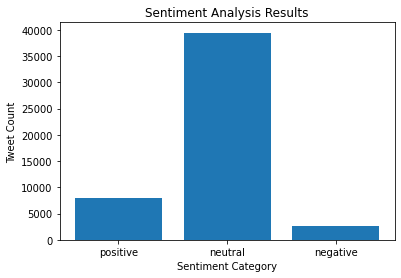

In [20]:
import matplotlib.pyplot as plt

# group the sentiment categories and count the number of tweets in each category
sentiment_counts = df_sentiment.groupBy("sentiment_category").count().collect()

# convert the results to a pandas dataframe for plotting
sentiment_counts_df = pd.DataFrame(sentiment_counts, columns=["sentiment_category", "count"])

# plot the sentiment counts as a bar graph
plt.bar(sentiment_counts_df["sentiment_category"], sentiment_counts_df["count"])
plt.title("Sentiment Analysis Results")
plt.xlabel("Sentiment Category")
plt.ylabel("Tweet Count")
plt.show()
